In [2]:
pip install auto-sklearn

  Using cached auto-sklearn-0.15.0.tar.gz (6.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
  Using cached pyrfr-0.8.3.tar.gz (293 kB)
     |████████████████████████████████| 1.6 MB 3.8 MB/s eta 0:00:01
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)
     |████████████████████████████████| 11.3 MB 745 kB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 866 kB/s eta 0:00:01
  Using cached smac-1.2.tar.gz (260 kB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
     |████████████████████████████████| 1.2 MB 968 kB/s eta 0:00:01
  Using cached distro-1.9.0-py3-none-any.whl (20 kB)
  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies ... error
  ERROR: Command errored out with exit status 1:
   command: /Users/t

In [ ]:
from sqlalchemy import create_engine
import pandas as pd

# Database connection details
host = 'localhost'
port = '5432'  # Default PostgreSQL port is 5432
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'

# Create the SQLAlchemy engine
engine = create_engine(connection_string)

# Query to fetch data from the database
query = "SELECT * FROM public.currentversions ORDER BY id ASC LIMIT 10000"

# Loading data into a pandas DataFrame
try:
    df = pd.read_sql_query(query, engine)
    print(df.head())
except Exception as e:
    print(f"An error occurred while querying the database: {e}")
finally:
    # Dispose of the engine (close the connection)
    engine.dispose()

In [ ]:
df.info()

df.describe()



In [ ]:
df.describe(include='all')

In [ ]:
df.shape # Returns (number_of_rows, number_of_columns)

In [ ]:
df.isnull().sum()

In [ ]:
n = 100  # Replace with the desired row number (0-based index)
nth_entry = df.loc[n, ['url', 'maintext','image_url']]

print(nth_entry)

print(nth_entry['url'])
print(nth_entry['image_url'])
#print()

In [ ]:
# https://github.com/MaartenGr/KeyBERT
# Article Keyword Generation - Method one keybert
from keybert import KeyBERT

doc = nth_entry['maintext']
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(doc)
kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 1), stop_words=None)
kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 2), stop_words=None)
keywords = kw_model.extract_keywords(doc, highlight=True)
print(keywords)

In [ ]:
# https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
kw_model = KeyBERT(model=model)
keywords = kw_model.extract_keywords(doc, highlight=True)
print(keywords)

In [ ]:
from flair.embeddings import TransformerDocumentEmbeddings
roberta = TransformerDocumentEmbeddings('roberta-base')
kw_model = KeyBERT(model=roberta)
keywords = kw_model.extract_keywords(doc, highlight=True)
print(keywords)

In [ ]:
# https://huggingface.co/valurank/MiniLM-L6-Keyword-Extraction
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
kw_model = KeyBERT(model=model)
keywords = kw_model.extract_keywords(doc, highlight=True)
print(keywords)

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
query = keywords_table.select()
df = pd.read_sql_query(query, engine)

# Preprocess the keywords (e.g., remove NaNs)
df = df.dropna(subset=['keywords'])

# Vectorize the keywords using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['keywords'])

# Silhouette Method to find the optimal number of clusters
silhouette_scores = []
range_n_clusters = range(2, 11)  # You can adjust the range as needed

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
## Hierarchical Clustering
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
import seaborn as sns

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
query = keywords_table.select()
df = pd.read_sql_query(query, engine)

# Preprocess the keywords (e.g., remove NaNs)
df = df.dropna(subset=['keywords'])

# Vectorize the keywords using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['keywords'])

#vectorizer = CountVectorizer(stop_words='english')
#X = vectorizer.fit_transform(df['keywords'])

#model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
#X = model.encode(df['keywords'])

# Apply Hierarchical Clustering
num_clusters = 5  # You can change the number of clusters
clustering = AgglomerativeClustering(n_clusters=num_clusters)
df['cluster'] = clustering.fit_predict(X.toarray())

# Analyze and visualize the clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df)
plt.title('Number of Keywords per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Keywords')
plt.show()


In [ ]:
# DBScan Clustering
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
query = keywords_table.select()
df = pd.read_sql_query(query, engine)

# Preprocess the keywords (e.g., remove NaNs)
df = df.dropna(subset=['keywords'])

# Vectorize the keywords using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['keywords'])

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['cluster'] = dbscan.fit_predict(X)

# Analyze and visualize the clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df)
plt.title('Number of Keywords per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Keywords')
plt.show()


In [ ]:
# Mean Shift Clustering
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
query = keywords_table.select()
df = pd.read_sql_query(query, engine)

# Preprocess the keywords (e.g., remove NaNs)
df = df.dropna(subset=['keywords'])

# Vectorize the keywords using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['keywords'])

# Apply Mean Shift clustering
mean_shift = MeanShift()
df['cluster'] = mean_shift.fit_predict(X.toarray())

# Analyze and visualize the clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df)
plt.title('Number of Keywords per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Keywords')
plt.show()

In [8]:
import h2o
from h2o.automl import H2OAutoML
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table
import logging
from tqdm import tqdm

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize H2O
h2o.init()

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
logging.info("Fetching keywords from the database")
query = keywords_table.select().limit(1000)  # Limit to 1000 samples
df = pd.read_sql_query(query, engine)

# Preprocess the keywords (e.g., remove NaNs)
df = df.dropna(subset=['keywords'])
logging.info(f"Loaded {df.shape[0]} rows from the database")

# Add a response column to the DataFrame
df['response'] = [
    'Politics', 'Business', 'Technology', 'Science', 'Health', 'Sports', 'Entertainment',
    'Environment', 'Education', 'World', 'National', 'Local', 'Opinion', 'Lifestyle',
    'Travel', 'Food', 'Fashion', 'Art', 'Culture', 'Crime', 'Weather', 'Real Estate',
    'Automotive', 'Finance', 'Economy', 'History', 'Religion', 'Law', 'Military',
    'Social Issues'
]

# Vectorize the keywords using TF-IDF
logging.info("Vectorizing the keywords using TF-IDF")
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['keywords'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Add the response column to the TF-IDF DataFrame
tfidf_df['response'] = df['response'].values

# Convert the DataFrame to an H2OFrame
h2o_df = h2o.H2OFrame(tfidf_df)

# Specify the response column
response_column = 'response'

# Run H2O AutoML
logging.info("Running H2O AutoML")
aml = H2OAutoML(max_runtime_secs=3600, project_name="keyword_clustering", exclude_algos=["DeepLearning", "StackedEnsemble"])
aml.train(x=[col for col in h2o_df.columns if col != response_column], y=response_column, training_frame=h2o_df)

# Get the best model
logging.info("Getting the best model")
best_model = aml.leader

# Predict clusters
logging.info("Predicting clusters")
predictions = best_model.predict(h2o_df)

# Convert predictions to a pandas DataFrame
predictions_df = h2o.as_list(predictions)

# Add the cluster labels to the original DataFrame
df['cluster'] = predictions_df['predict']

# Analyze and visualize the clusters
logging.info("Visualizing the clusters")
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df)
plt.title('Number of Keywords per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Keywords')
plt.show()

# Shutdown H2O
logging.info("Shutting down H2O")
h2o.shutdown()

        id  document_id                      keywords       response
0    10245        11542  keyword1, keyword2, keyword3       Politics
1    10246        11543  keyword1, keyword2, keyword3       Religion
2    10247        11544  keyword1, keyword2, keyword3          World
3    10248        11545  keyword1, keyword2, keyword3      Education
4    10249        11546  keyword1, keyword2, keyword3  Social Issues
..     ...          ...                           ...            ...
995  11240        12537  keyword1, keyword2, keyword3       Politics
996  11241        12538  keyword1, keyword2, keyword3     Technology
997  11242        12539  keyword1, keyword2, keyword3           Food
998  11243        12540  keyword1, keyword2, keyword3         Health
999  11244        12541  keyword1, keyword2, keyword3       National

[1000 rows x 4 columns]


2024-12-10 13:36:02,079 - INFO - Fetching keywords from the database


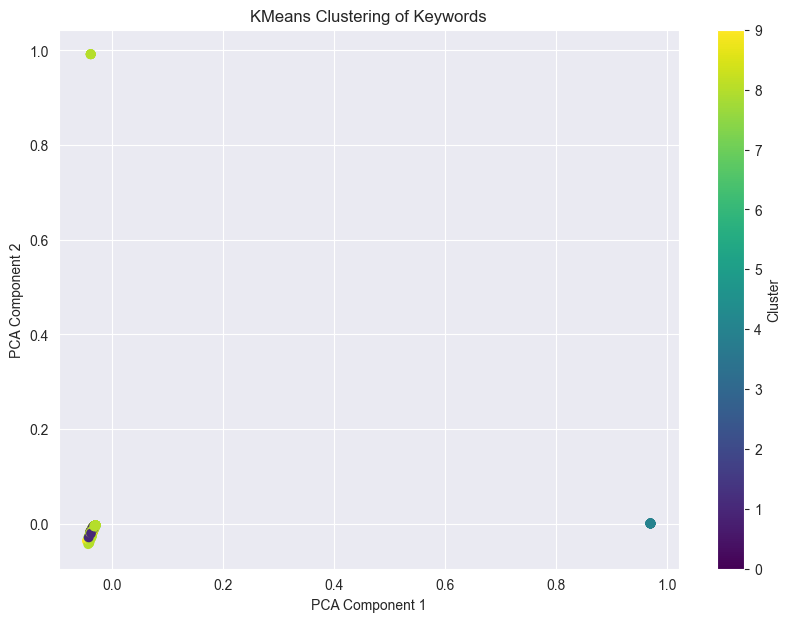

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
logging.info("Fetching keywords from the database")
query = keywords_table.select().limit(1000)  # Limit to 1000 samples
df = pd.read_sql_query(query, engine)

# Vectorize the keywords
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['keywords'])

# Determine the optimal number of clusters using silhouette score
range_n_clusters = list(range(2, 11))
best_n_clusters = 2
best_silhouette_score = -1

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', marker='o')
plt.title('KMeans Clustering of Keywords')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

                        keyword  frequency
4                       Schweiz      27562
66982                 Countdown      15269
26796                     Tipps      15192
8767                      Spiel      14727
54                      Unknown      13265
...                         ...        ...
180395          Schülerbewegung          1
180396    globale Verantwortung          1
180398   Entwicklungsengagement          1
180399         lokale Gemeinden          1
370361             East Village          1

[370362 rows x 2 columns]


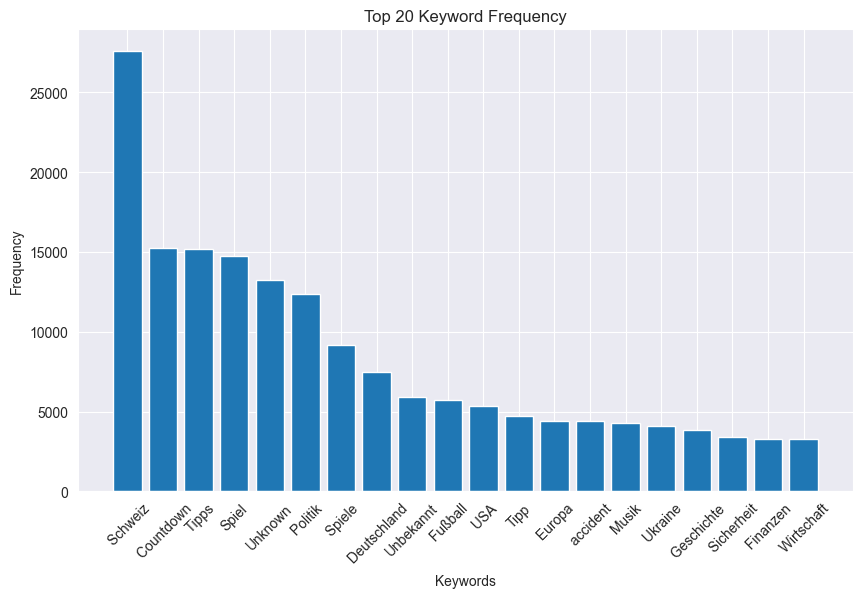

In [20]:
# Keyword Frequency Analysis
import pandas as pd
from collections import Counter
from sqlalchemy import create_engine, MetaData, Table

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
query = keywords_table.select()
df = pd.read_sql_query(query, engine)

# Split keywords and count frequency
all_keywords = df['keywords'].str.split(',').explode()
keyword_counts = Counter(all_keywords)

# Convert to DataFrame for analysis
keyword_freq_df = pd.DataFrame(keyword_counts.items(), columns=['keyword', 'frequency'])
keyword_freq_df = keyword_freq_df.sort_values(by='frequency', ascending=False)

print(keyword_freq_df)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(keyword_freq_df['keyword'][:20], keyword_freq_df['frequency'][:20])  # Plot top 20 keywords
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Top 20 Keyword Frequency')
plt.xticks(rotation=45)
plt.show()


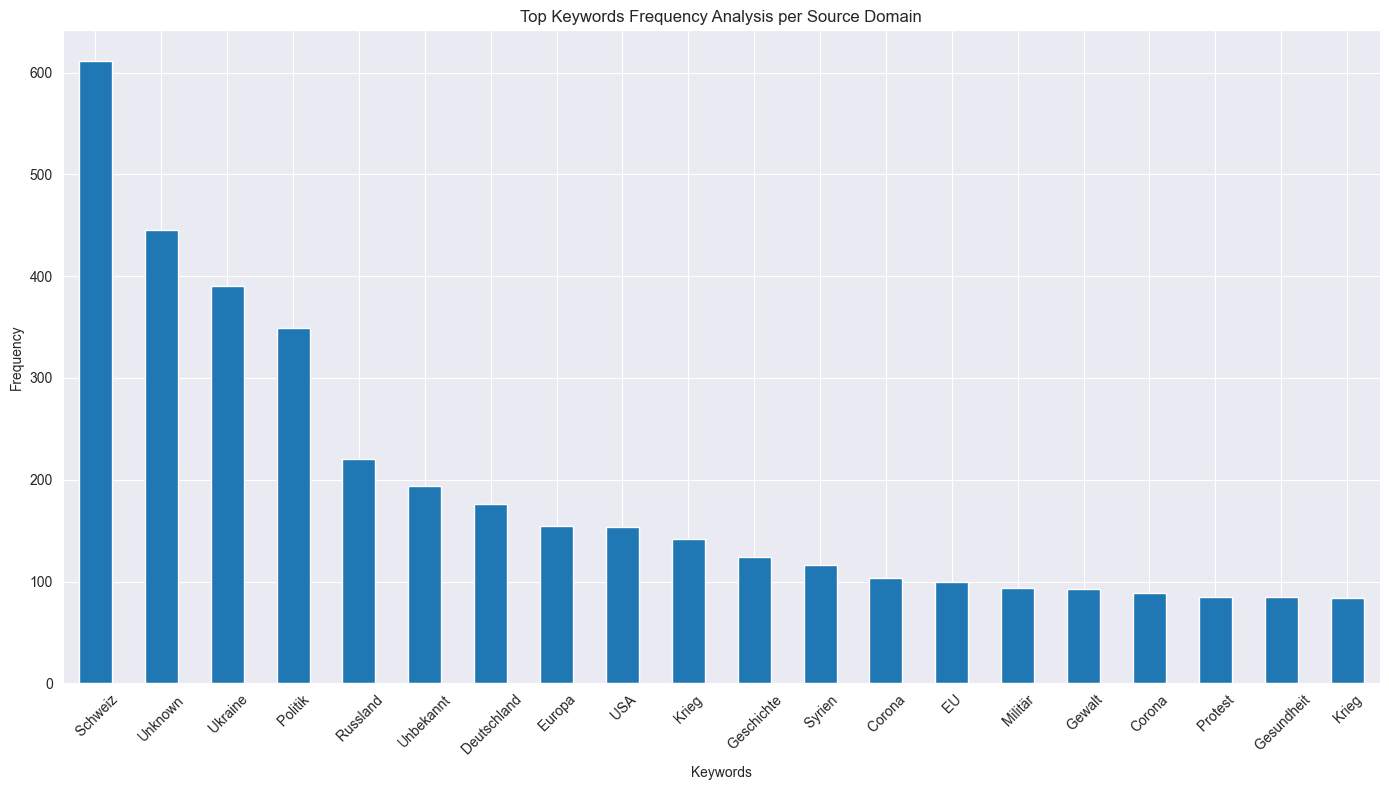

In [5]:
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table
import matplotlib.pyplot as plt

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the tables
currentversions_table = Table('currentversions', metadata, autoload_with=engine)
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the data from the database
query_currentversions = currentversions_table.select().limit(10000)
df_currentversions = pd.read_sql_query(query_currentversions, engine)

query_keywords = keywords_table.select().limit(10000)
df_keywords = pd.read_sql_query(query_keywords, engine)

# Merge the data on the id and document_id columns
merged_df = pd.merge(df_keywords, df_currentversions, left_on='document_id', right_on='id')

# Filter out keywords longer than 10 words
merged_df['keywords'] = merged_df['keywords'].apply(lambda x: ','.join([kw for kw in x.split(',') if len(kw.split()) <= 10]))

# Perform the frequency analysis of the keywords per source_domain
keyword_freq = merged_df.groupby('source_domain')['keywords'].apply(lambda x: ','.join(x)).str.split(',', expand=True).stack().value_counts()

# Select the top N keywords for visualization
top_n = 20
top_keywords = keyword_freq.head(top_n)

# Plot the results
plt.figure(figsize=(14, 8))
top_keywords.plot(kind='bar')
plt.title('Top Keywords Frequency Analysis per Source Domain')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2024-12-10 15:12:38,410 - INFO - Fetching data from the keywords table
2024-12-10 15:12:42,475 - INFO - Fetched 513701 rows from keywords table
2024-12-10 15:12:42,483 - INFO - Fetching data from the currentversions table using document_id from keywords table
2024-12-10 15:14:50,109 - INFO - Fetched 513701 rows from currentversions table
2024-12-10 15:14:50,110 - INFO - Merging data on id and document_id columns
2024-12-10 15:14:50,685 - INFO - Merged dataframe has 513701 rows
2024-12-10 15:14:50,686 - INFO - Filtering out keywords longer than 10 words
2024-12-10 15:14:51,272 - INFO - Generating plots for each source domain
2024-12-10 15:14:51,276 - INFO - Processing source domain: woz.ch
2024-12-10 15:14:51,599 - INFO - Processing source domain: 20min.ch
2024-12-10 15:14:52,410 - INFO - Processing source domain: srf.ch
2024-12-10 15:14:52,961 - INFO - Processing source domain: tagblatt.ch
2024-12-10 15:14:53,612 - INFO - Processing source domain: tagesanzeiger.ch
2024-12-10 15:14:54,0

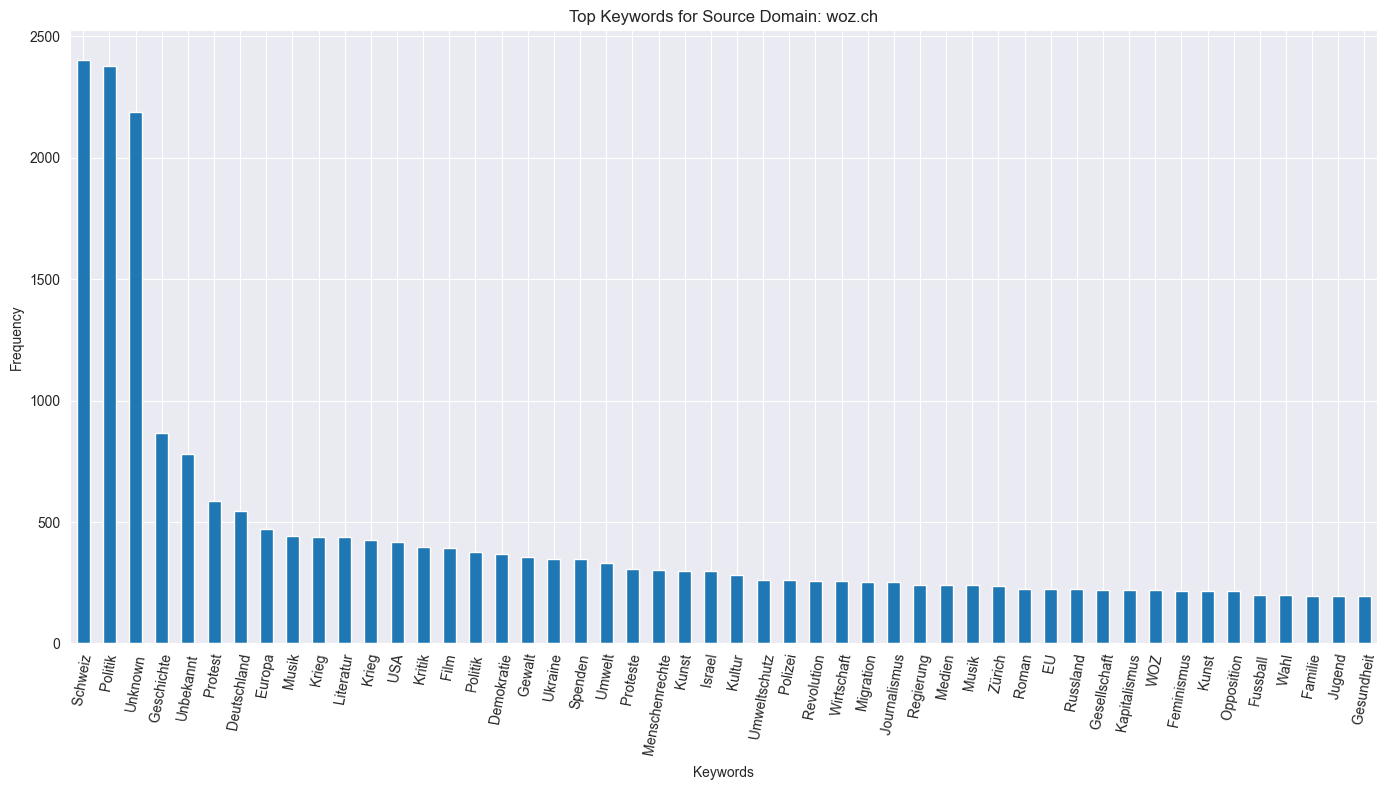

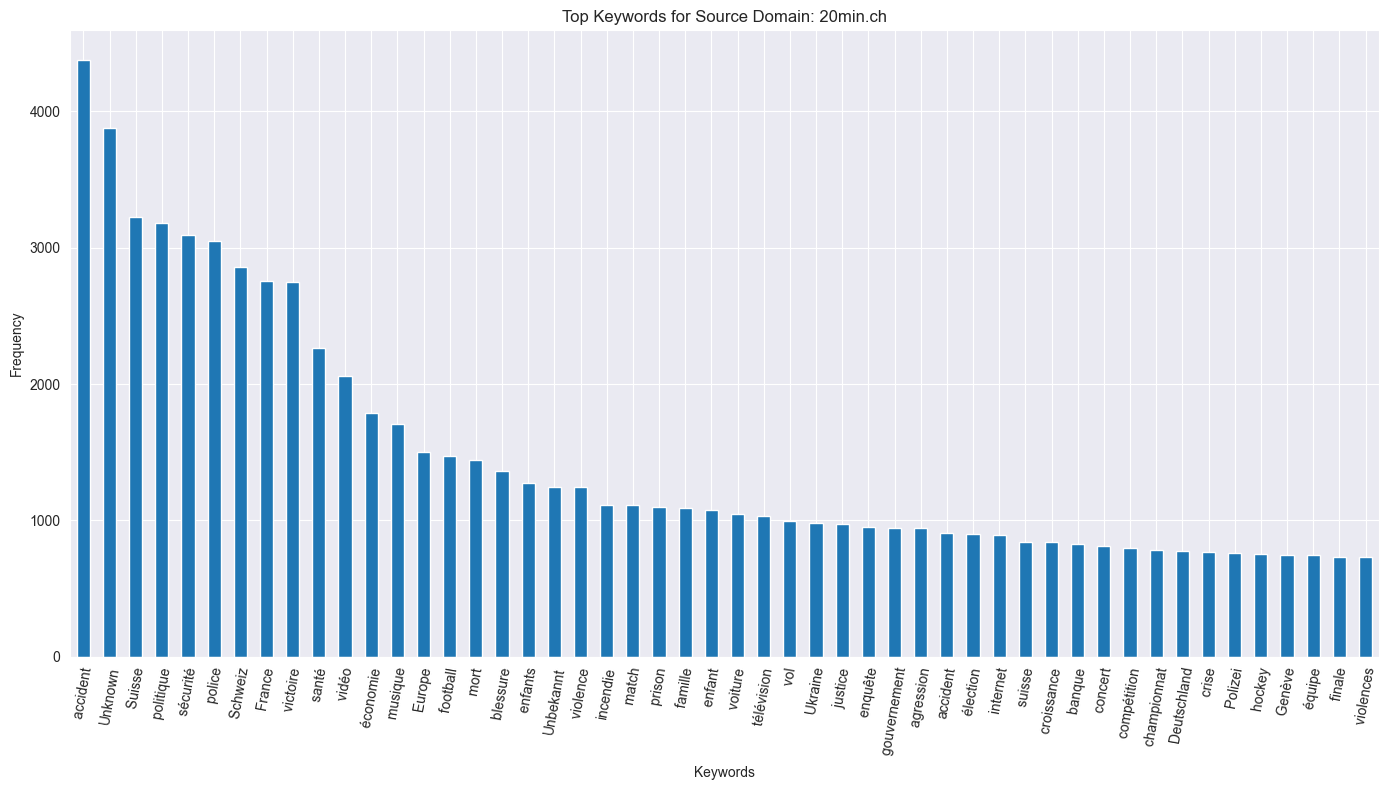

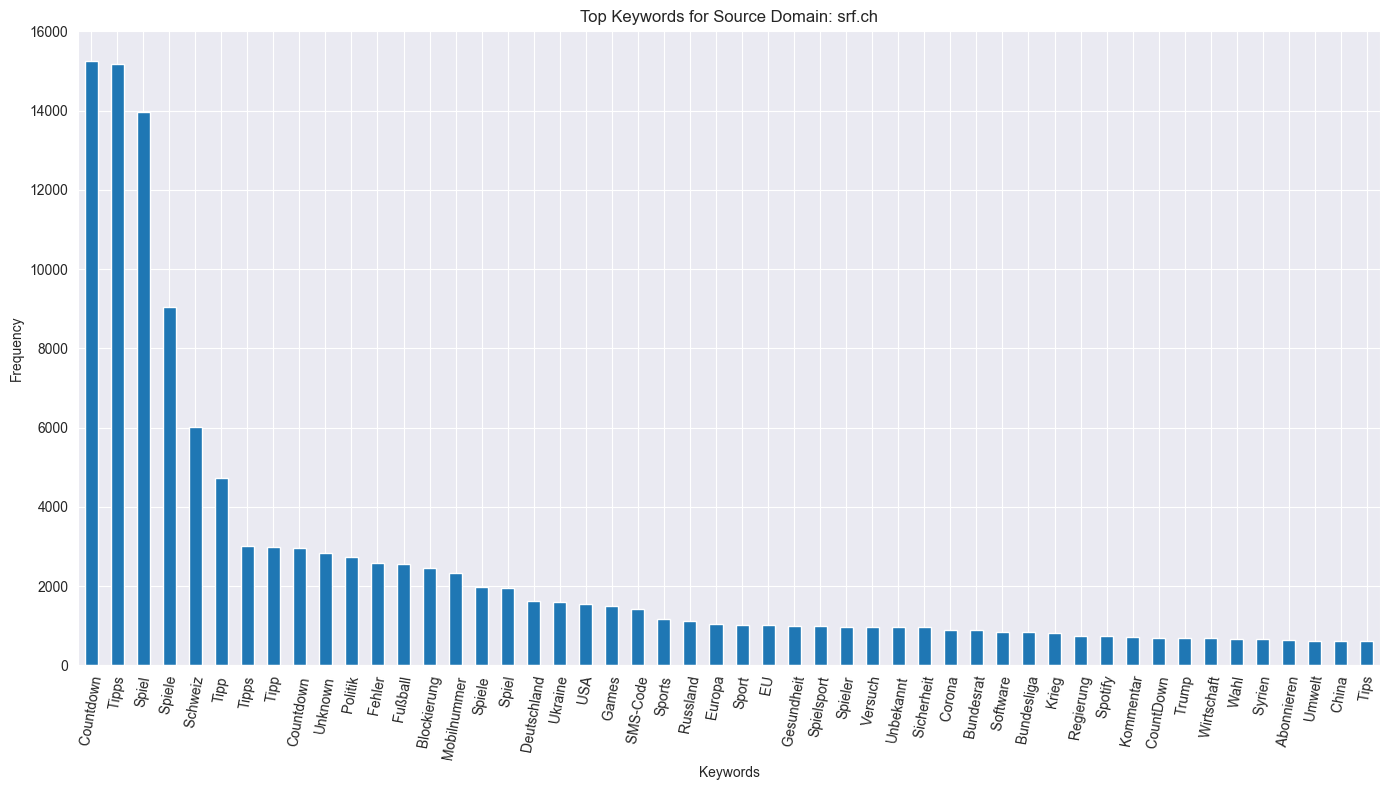

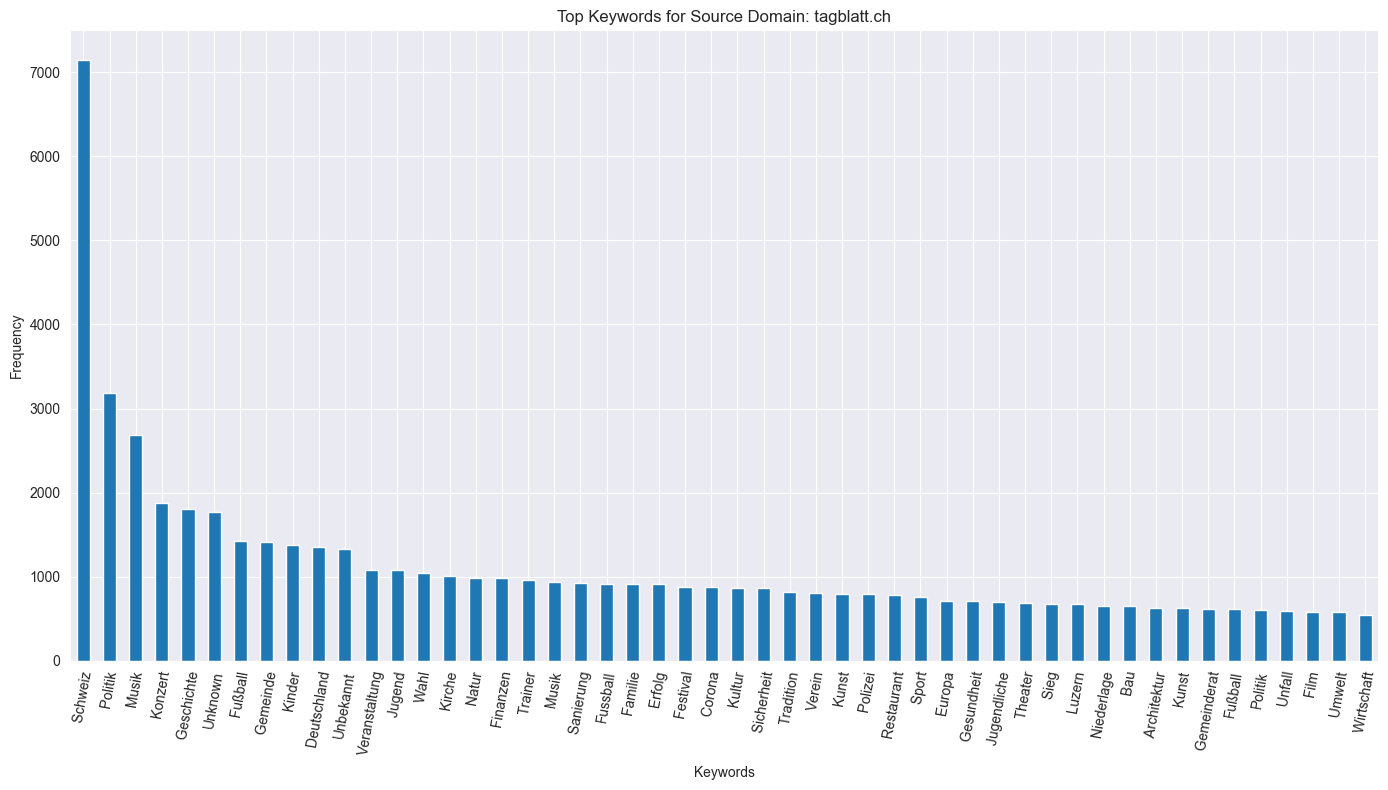

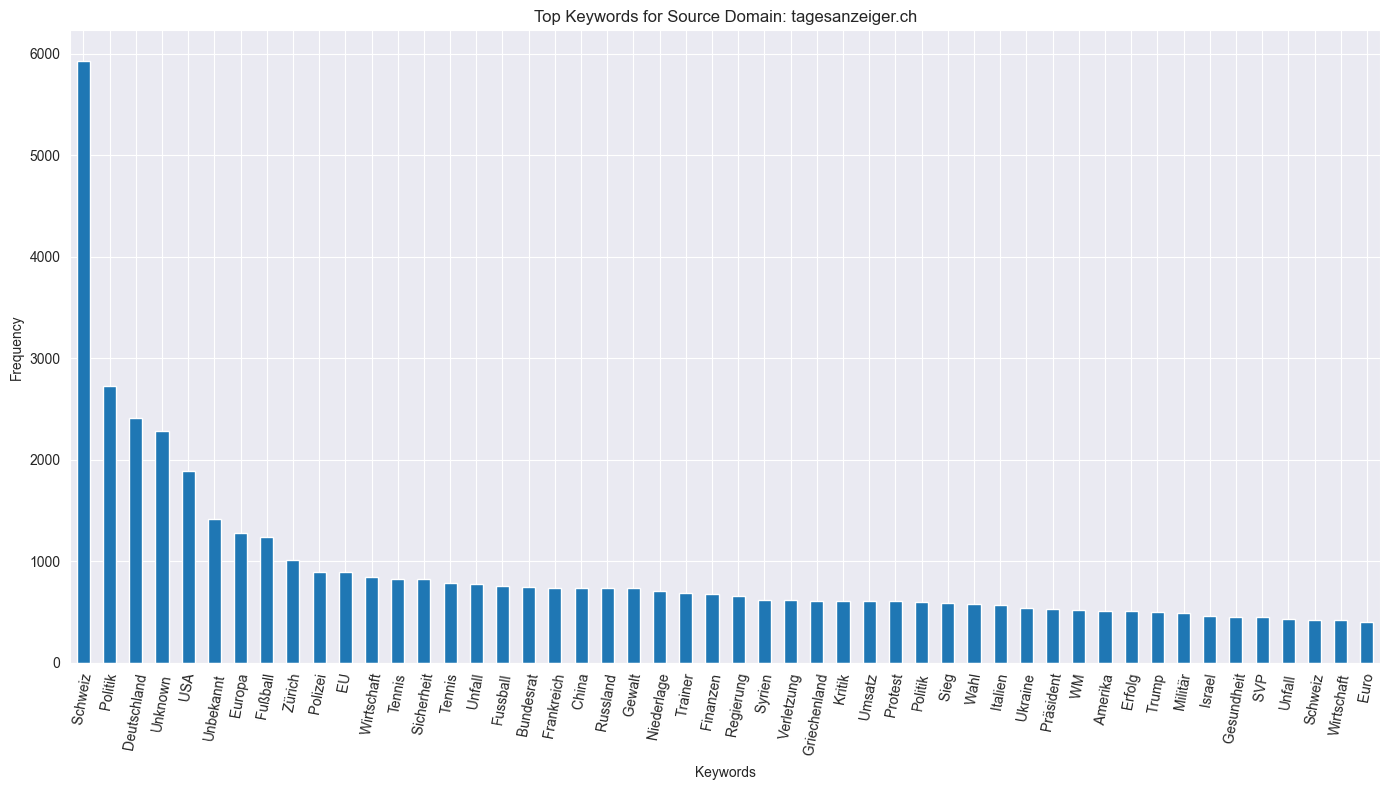

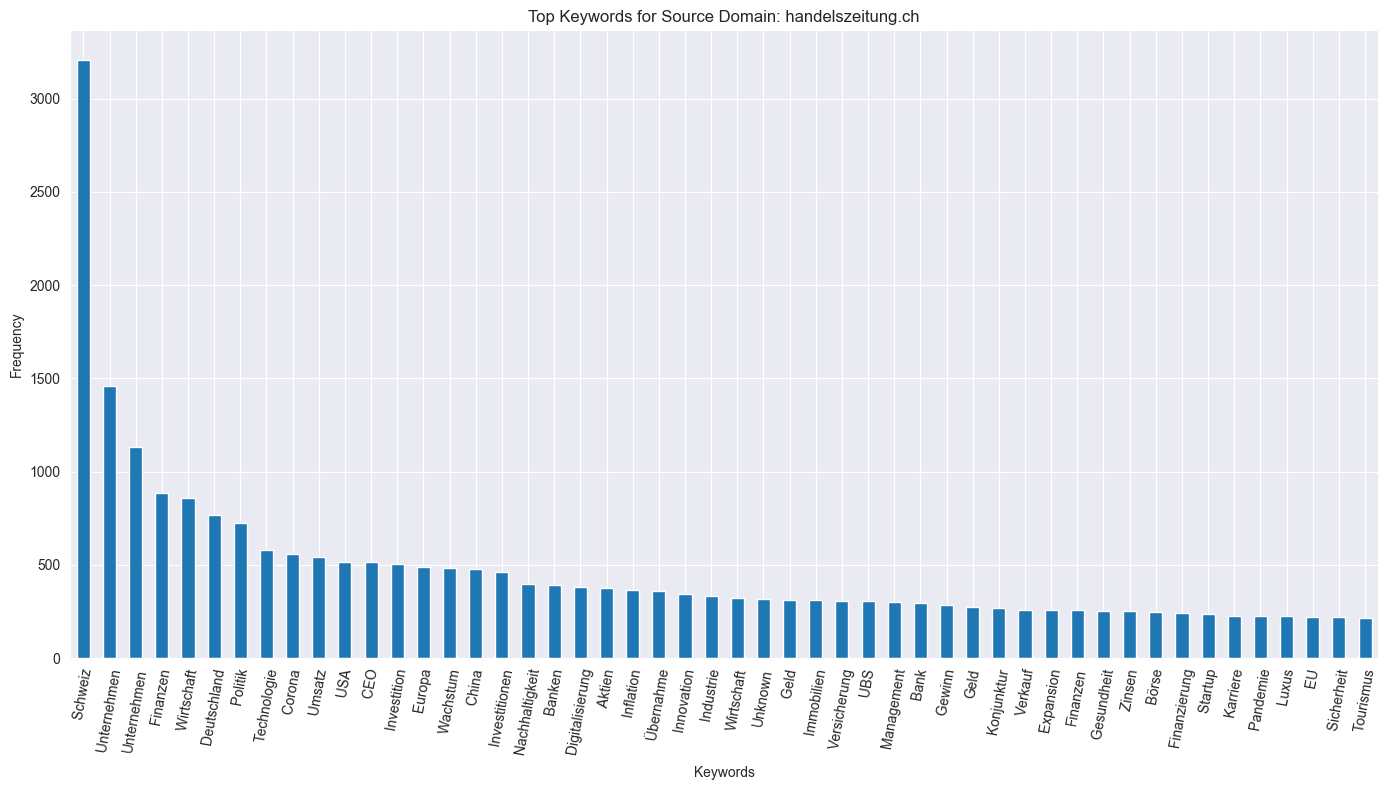

In [17]:
# Frequency of keywords per source domain
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define tables
currentversions_table = Table('currentversions', metadata, autoload_with=engine)
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch data from keywords table
logging.info("Fetching data from the keywords table")
query_keywords = keywords_table.select()
df_keywords = pd.read_sql_query(query_keywords, engine)
logging.info(f"Fetched {len(df_keywords)} rows from keywords table")

# Fetch data from currentversions table using document_id from keywords table
document_ids = df_keywords['document_id'].tolist()
logging.info("Fetching data from the currentversions table using document_id from keywords table")
query_currentversions = currentversions_table.select().where(currentversions_table.c.id.in_(document_ids))
df_currentversions = pd.read_sql_query(query_currentversions, engine)
logging.info(f"Fetched {len(df_currentversions)} rows from currentversions table")

# Merge the data on the id and document_id columns
logging.info("Merging data on id and document_id columns")
merged_df = pd.merge(df_keywords, df_currentversions, left_on='document_id', right_on='id')
logging.info(f"Merged dataframe has {len(merged_df)} rows")

# Filter out keywords longer than 10 words
logging.info("Filtering out keywords longer than 10 words")
merged_df['keywords'] = merged_df['keywords'].apply(lambda x: ','.join([kw for kw in x.split(',') if len(kw.split()) <= 10]))

# Plot the top keywords for each source_domain
source_domains = merged_df['source_domain'].unique()
top_n = 50  # Number of top keywords to display

logging.info("Generating plots for each source domain")
for domain in source_domains:
    logging.info(f"Processing source domain: {domain}")
    domain_df = merged_df[merged_df['source_domain'] == domain]
    keyword_freq = domain_df['keywords'].str.split(',', expand=True).stack().value_counts().head(top_n)
    plt.figure(figsize=(14, 8))
    keyword_freq.plot(kind='bar')
    plt.title(f'Top Keywords for Source Domain: {domain}')
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.xticks(rotation=80)
    plt.tight_layout()

logging.info("Displaying plots")
plt.show()

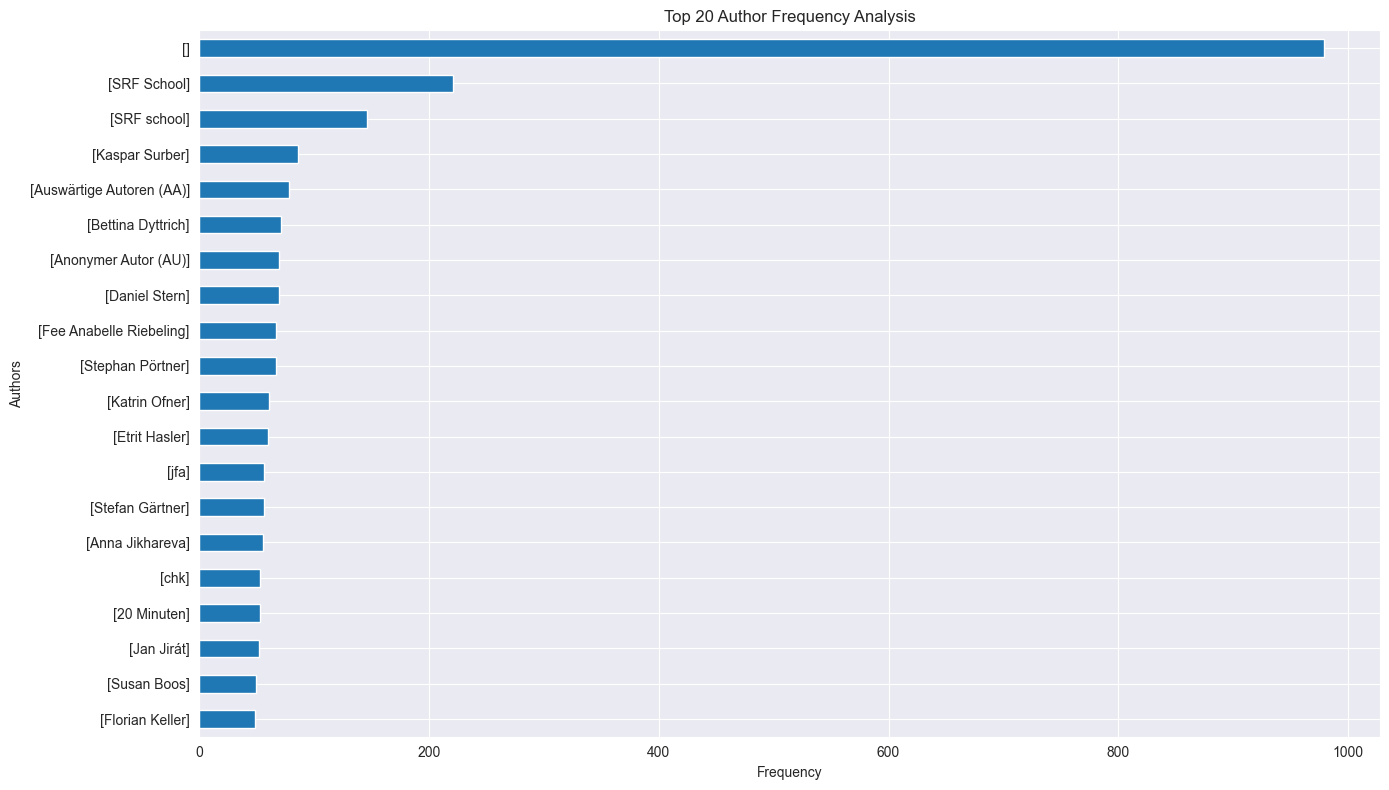

In [19]:
# Frequency of Authors on all Articles
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table
import matplotlib.pyplot as plt

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the table
currentversions_table = Table('currentversions', metadata, autoload_with=engine)

# Fetch the data from the database
query_currentversions = currentversions_table.select().limit(10000)
df_currentversions = pd.read_sql_query(query_currentversions, engine)

# Frequency analysis of authors
author_freq = df_currentversions['authors'].value_counts()

# Plot the top 20 authors
top_n = 20
plt.figure(figsize=(14, 8))
author_freq.head(top_n).plot(kind='barh')
plt.title('Top 20 Author Frequency Analysis overall')
plt.xlabel('Frequency')
plt.ylabel('Authors')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.tight_layout()
plt.show()

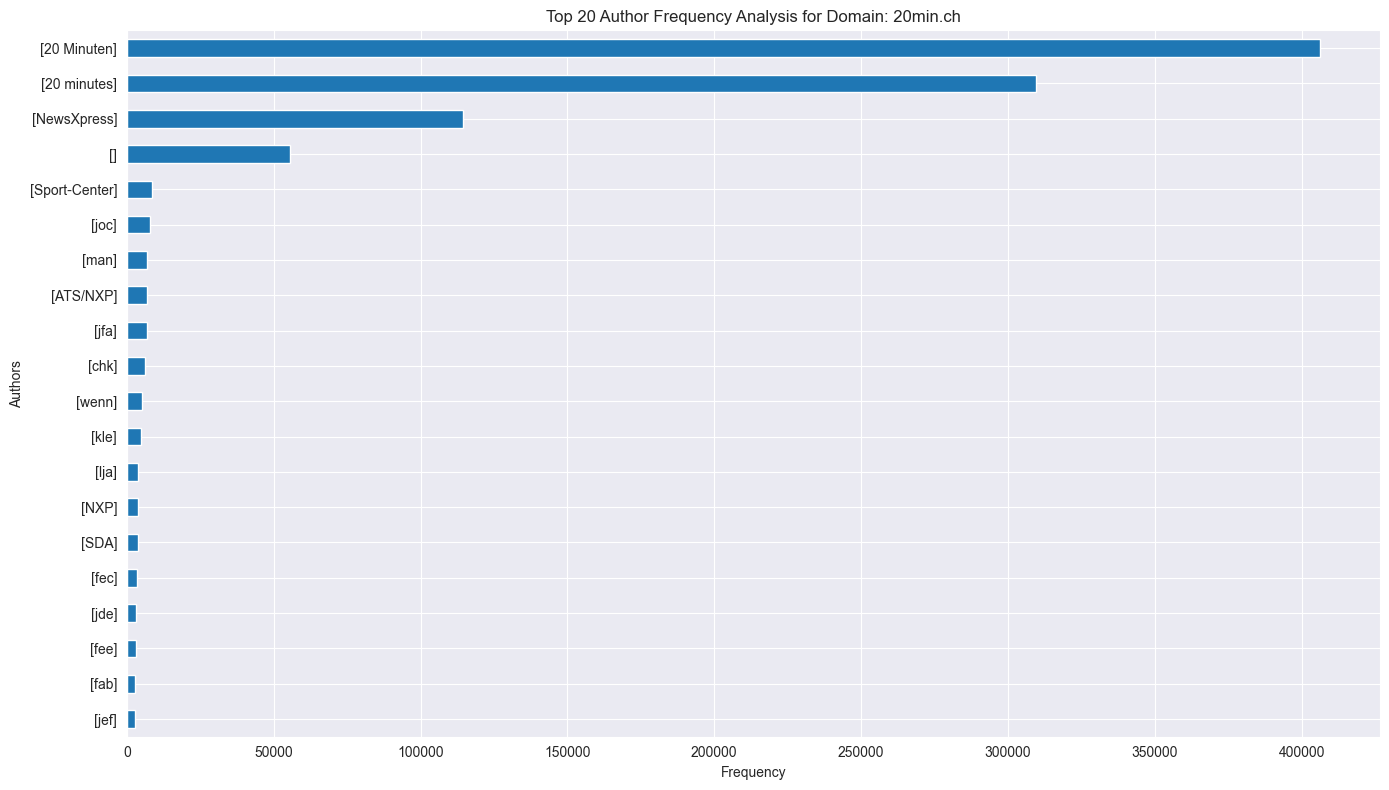

In [ ]:
# Frequency of Authors per domain

import pandas as pd
from sqlalchemy import create_engine, MetaData, Table
import matplotlib.pyplot as plt

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the table
currentversions_table = Table('currentversions', metadata, autoload_with=engine)

# Fetch the data from the database
query_currentversions = currentversions_table.select().limit(50000)
df_currentversions = pd.read_sql_query(query_currentversions, engine)

# Group by domain and analyze author frequency within each domain
domains = df_currentversions['source_domain'].unique()
for domain in domains:
    domain_df = df_currentversions[df_currentversions['source_domain'] == domain]
    author_freq = domain_df['authors'].value_counts()

    # Plot the top 20 authors for each domain
    top_n = 20
    plt.figure(figsize=(14, 8))
    author_freq.head(top_n).plot(kind='barh')
    plt.title(f'Top 20 Author Frequency Analysis for Domain: {domain}')
    plt.xlabel('Frequency')
    plt.ylabel('Authors')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
    plt.tight_layout()
    plt.show()


2024-12-10 17:54:10,857 - INFO - Fetching data from the database...
2024-12-10 17:54:12,789 - INFO - Fetched 1000 rows from the database.
2024-12-10 17:54:12,789 - INFO - Grouping data by source_domain and counting entries...
2024-12-10 17:54:12,790 - INFO - Data grouped and counted.
2024-12-10 17:54:12,790 - INFO - Plotting the number of articles per source_domain...


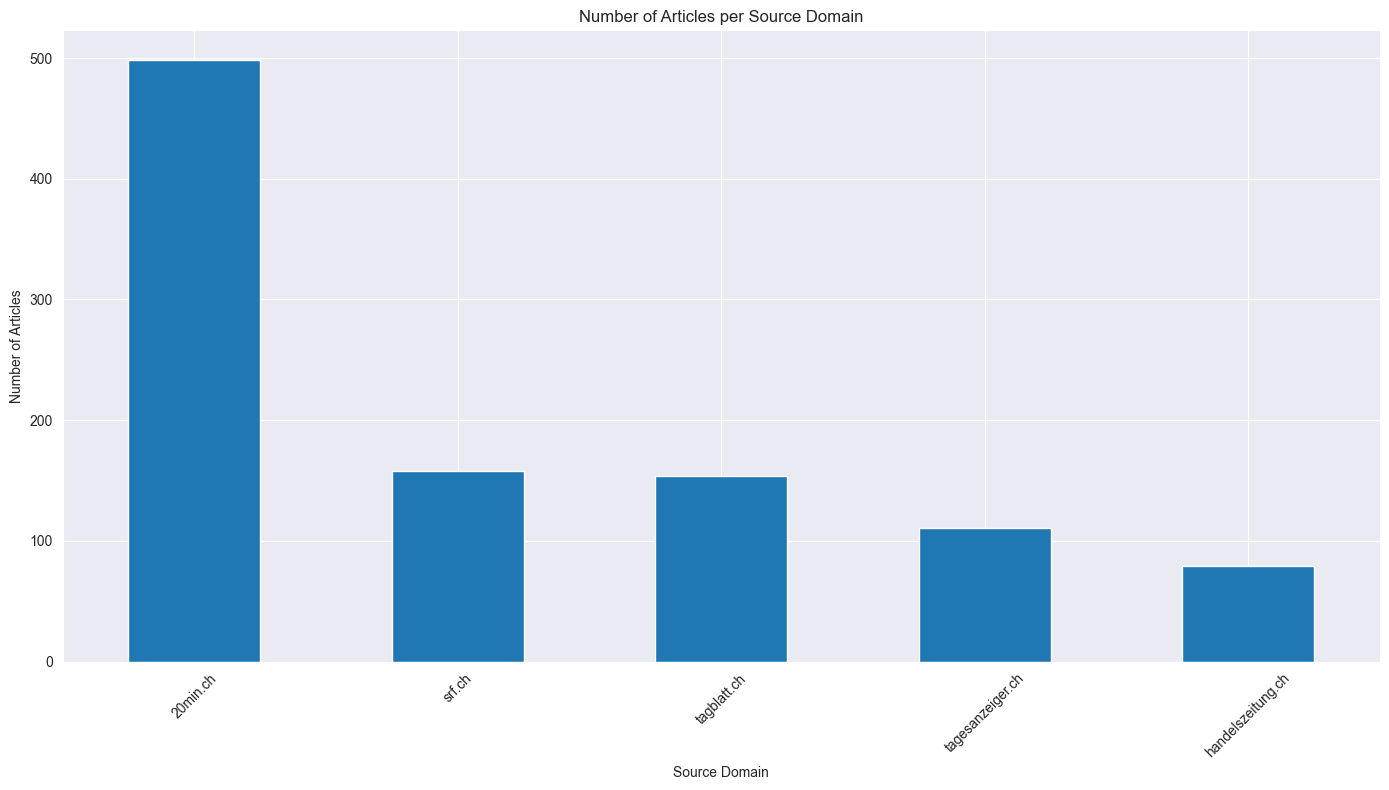

2024-12-10 17:54:13,076 - INFO - Plot displayed.


In [18]:
# Number of Articles per Domain
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the table
currentversions_table = Table('currentversions', metadata, autoload_with=engine)

# Fetch the data from the database
logging.info('Fetching data from the database...')
query_currentversions = currentversions_table.select().limit(1000)
df_currentversions = pd.read_sql_query(query_currentversions, engine)
logging.info(f'Fetched {len(df_currentversions)} rows from the database.')

# Group by source_domain and count the number of entries
logging.info('Grouping data by source_domain and counting entries...')
domain_counts = df_currentversions['source_domain'].value_counts()
logging.info('Data grouped and counted.')

# Plot the number of articles per source_domain
logging.info('Plotting the number of articles per source_domain...')
plt.figure(figsize=(14, 8))
domain_counts.plot(kind='bar')
plt.title('Number of Articles per Source Domain')
plt.xlabel('Source Domain')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
pdf_filename = "Number_of_Articles_per_Domain.pdf"
plt.savefig(pdf_filename, format='pdf')
plt.show()

logging.info('Plot displayed.')

2024-12-10 15:54:47,521 - INFO - Fetching data from the database...
2024-12-10 15:54:49,721 - INFO - Fetched 10000 rows from the database.
2024-12-10 15:54:49,722 - INFO - Filtering data for fall of 2024...
2024-12-10 15:54:49,728 - INFO - Filtered data contains 676 rows.
2024-12-10 15:54:49,729 - INFO - Grouping data by date and counting entries...
2024-12-10 15:54:49,730 - INFO - Data grouped and counted.
2024-12-10 15:54:49,730 - INFO - Plotting the number of articles per date...


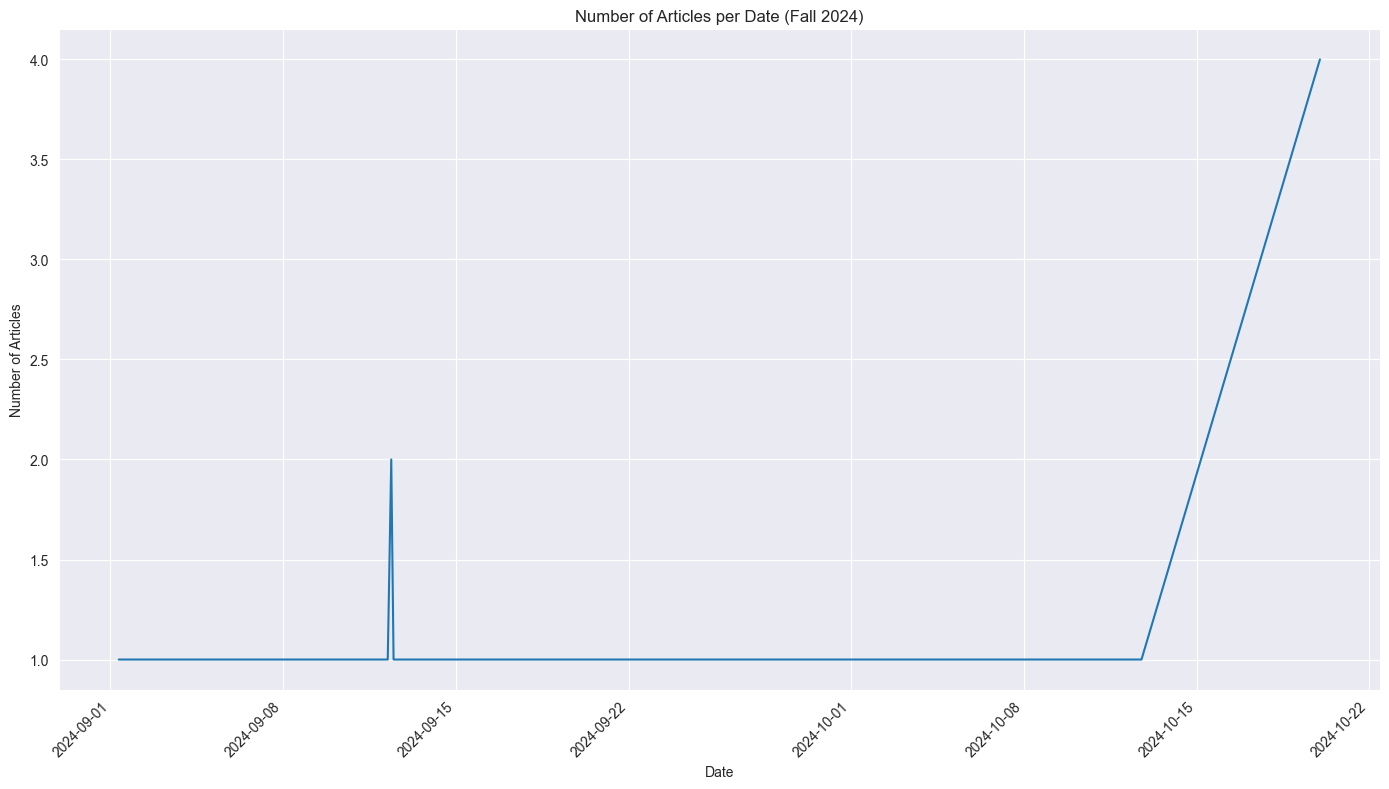

2024-12-10 15:54:49,934 - INFO - Plot displayed.


In [5]:
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the table
currentversions_table = Table('currentversions', metadata, autoload_with=engine)

# Fetch the data from the database
logging.info('Fetching data from the database...')
query_currentversions = currentversions_table.select().limit(10000)
df_currentversions = pd.read_sql_query(query_currentversions, engine)
logging.info(f'Fetched {len(df_currentversions)} rows from the database.')

# Filter data for fall of 2024
logging.info('Filtering data for fall of 2024...')
df_currentversions['date'] = pd.to_datetime(df_currentversions['date_publish'])
fall_2024 = df_currentversions[(df_currentversions['date'] >= '2024-09-01') & (df_currentversions['date_publish'] <= '2024-11-30')]
logging.info(f'Filtered data contains {len(fall_2024)} rows.')

# Group by date and count the number of entries
logging.info('Grouping data by date and counting entries...')
date_counts = fall_2024['date_publish'].value_counts().sort_index()
logging.info('Data grouped and counted.')

# Plot the number of articles per date
logging.info('Plotting the number of articles per date...')
plt.figure(figsize=(14, 8))
date_counts.plot(kind='line')
plt.title('Number of Articles per Date (Fall 2024)')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
logging.info('Plot displayed.')

2024-12-10 17:27:42,904 - INFO - Fetching data from the database...
2024-12-10 17:31:15,974 - INFO - Fetched 100000 rows from the database.
2024-12-10 17:31:15,985 - INFO - Plotting number of articles per date for each source_domain in fall 2024...


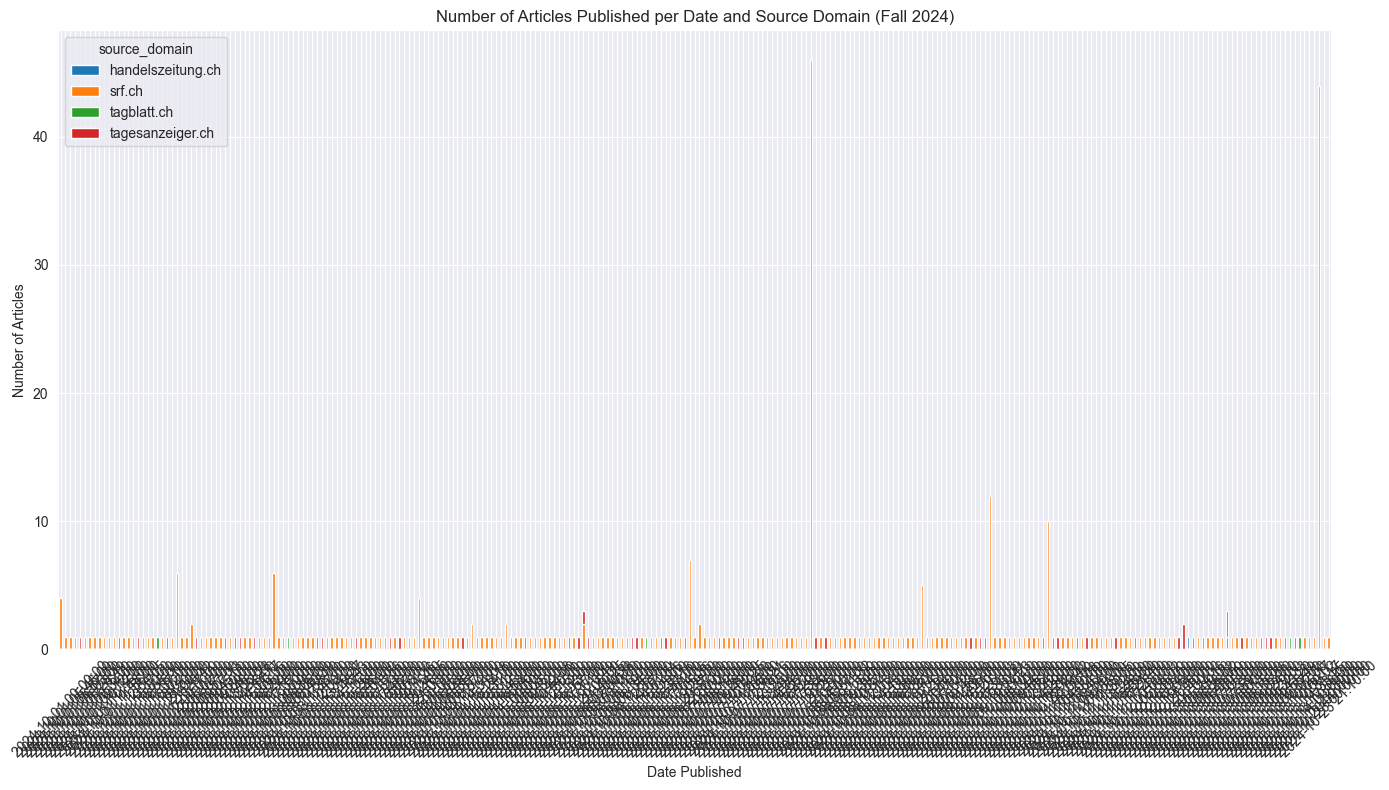

2024-12-10 17:31:17,449 - INFO - Plot displayed.


In [16]:
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the table
currentversions_table = Table('currentversions', metadata, autoload_with=engine)

# Fetch the data from the database
logging.info('Fetching data from the database...')
query_currentversions = currentversions_table.select().limit(100000)
df_currentversions = pd.read_sql_query(query_currentversions, engine)
logging.info(f'Fetched {len(df_currentversions)} rows from the database.')

# Convert date_published to datetime
df_currentversions['date_publish'] = pd.to_datetime(df_currentversions['date_publish'])

# Filter data for fall 2024
start_date = '2024-10-01'
end_date = '2024-10-30'
df_fall_2024 = df_currentversions[(df_currentversions['date_publish'] >= start_date) & (df_currentversions['date_publish'] <= end_date)]

# Group by date_published and source_domain and count the number of articles
df_grouped = df_fall_2024.groupby(['date_publish', 'source_domain']).size().unstack(fill_value=0)

# Plot the number of articles per date for each source_domain
logging.info('Plotting number of articles per date for each source_domain in fall 2024...')
df_grouped.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Number of Articles Published per Date and Source Domain (Fall 2024)')
plt.xlabel('Date Published')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
logging.info('Plot displayed.')

In [21]:
# Keyword Co-occurrence
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter
from sqlalchemy import create_engine, MetaData, Table

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
query = keywords_table.select().limit(1000)
df = pd.read_sql_query(query, engine)

# Create co-occurrence matrix
keywords_list = df['keywords'].str.split(',')
co_occurrence = Counter()

for keywords in keywords_list:
    co_occurrence.update(combinations(sorted(keywords), 2))

# Convert to DataFrame for analysis
co_occurrence_df = pd.DataFrame(co_occurrence.items(), columns=['pair', 'count'])
co_occurrence_df[['keyword1', 'keyword2']] = pd.DataFrame(co_occurrence_df['pair'].tolist(), index=co_occurrence_df.index)
co_occurrence_df = co_occurrence_df.drop(columns=['pair'])

print(co_occurrence_df)

      count          keyword1     keyword2
0         4           Politik      Schweiz
1         1           Politik      Steuern
2         1           Politik   Wirtschaft
3         1           Politik     Pandemie
4         1           Schweiz      Steuern
...     ...               ...          ...
7457      1          héritage   patrimoine
7458      1          héritage        royal
7459      1   investissements   patrimoine
7460      1   investissements        royal
7461      1        patrimoine        royal

[7462 rows x 3 columns]


In [ ]:
# Heatmap Visualization - Keyword Co-occurrence --> Does not scale and is very slow
import pandas as pd
import numpy as np
from itertools import combinations
from sqlalchemy import create_engine, MetaData, Table
import seaborn as sns
import matplotlib.pyplot as plt

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
query = keywords_table.select().limit(1000)
df = pd.read_sql_query(query, engine)

# Split keywords and create co-occurrence matrix
all_keywords = df['keywords'].str.split(',').explode()
keyword_pairs = list(combinations(all_keywords.unique(), 2))
co_occurrence_matrix = pd.DataFrame(0, index=all_keywords.unique(), columns=all_keywords.unique())

for keywords in df['keywords']:
    keywords_list = keywords.split(',')
    for pair in combinations(keywords_list, 2):
        co_occurrence_matrix.loc[pair[0], pair[1]] += 1
        co_occurrence_matrix.loc[pair[1], pair[0]] += 1

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Keyword Co-occurrence Heatmap')
plt.show()

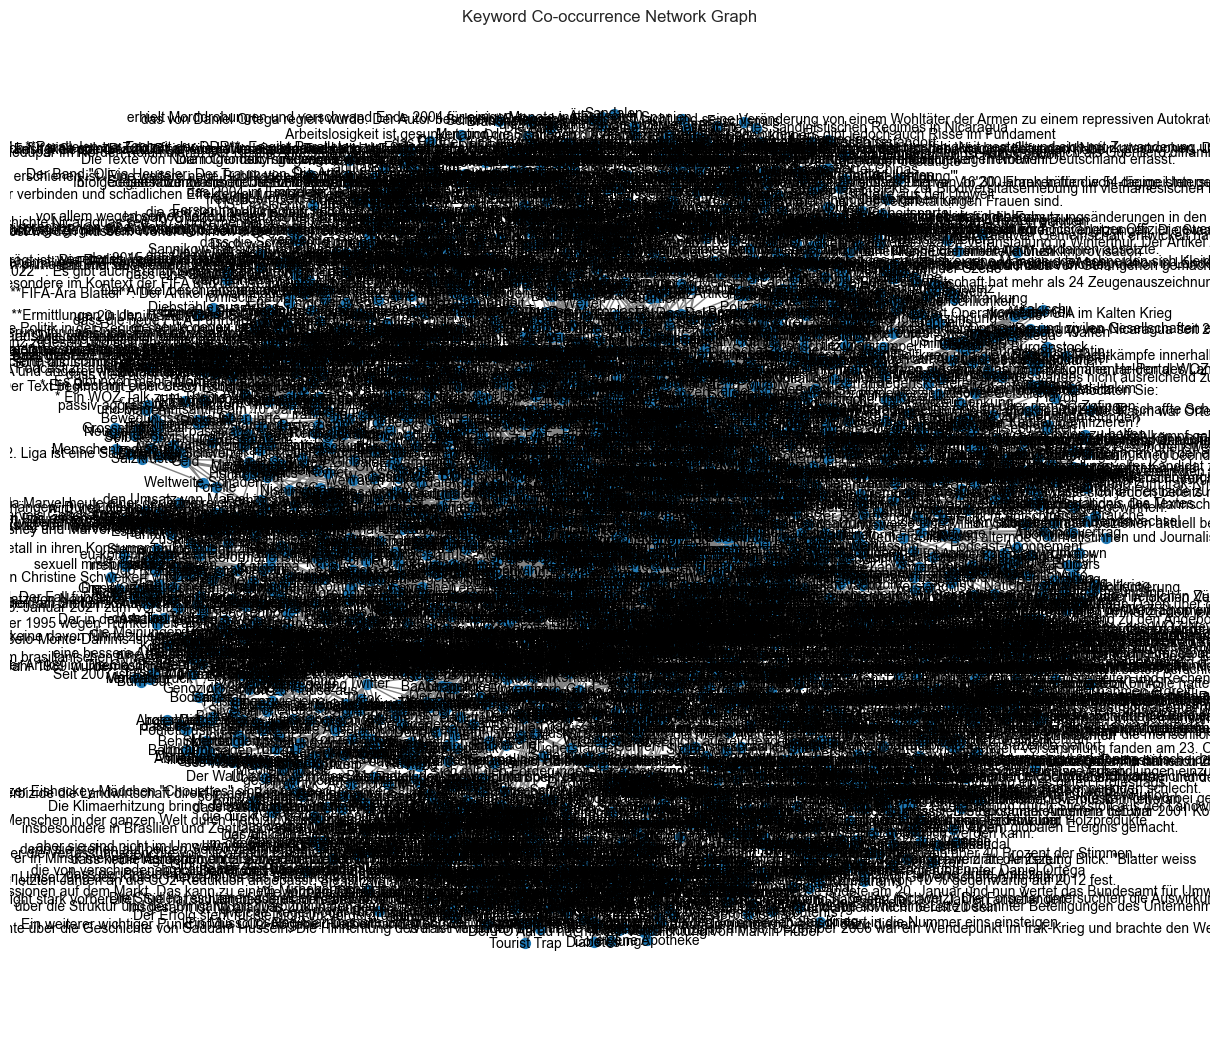

In [17]:
# Network Graph Visualization
import pandas as pd
import numpy as np
from itertools import combinations
from sqlalchemy import create_engine, MetaData, Table
import networkx as nx
import matplotlib.pyplot as plt

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
query = keywords_table.select().limit(1000)
df = pd.read_sql_query(query, engine)

# Split keywords and create co-occurrence matrix
all_keywords = df['keywords'].str.split(',').explode()
keyword_pairs = list(combinations(all_keywords.unique(), 2))
co_occurrence_matrix = pd.DataFrame(0, index=all_keywords.unique(), columns=all_keywords.unique())

for keywords in df['keywords']:
    keywords_list = keywords.split(',')
    for pair in combinations(keywords_list, 2):
        co_occurrence_matrix.loc[pair[0], pair[1]] += 1
        co_occurrence_matrix.loc[pair[1], pair[0]] += 1

# Create network graph
G = nx.Graph()

for keyword in all_keywords.unique():
    G.add_node(keyword)

for pair in keyword_pairs:
    if co_occurrence_matrix.loc[pair[0], pair[1]] > 0:
        G.add_edge(pair[0], pair[1], weight=co_occurrence_matrix.loc[pair[0], pair[1]])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.1)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=10, edge_color='gray')
plt.title('Keyword Co-occurrence Network Graph')
plt.show()

In [ ]:
# Topic Modeling
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sqlalchemy import create_engine, MetaData, Table

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
query = keywords_table.select().limit(1000)
df = pd.read_sql_query(query, engine)

# Vectorize the keywords
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['keywords'])

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display topics
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print(" ".join([terms[i] for i in topic.argsort()[:-11:-1]]))

In [ ]:
# Clustering
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sqlalchemy import create_engine, MetaData, Table

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
query = keywords_table.select().limit(1000)
df = pd.read_sql_query(query, engine)

# Vectorize the keywords
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['keywords'])

# Determine the optimal number of clusters using silhouette score
range_n_clusters = list(range(2, 11))
best_n_clusters = 2
best_silhouette_score = -1

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    if silhouette_avg > best_silhouette_score:
        best_n_clusters = n_clusters
        best_silhouette_score = silhouette_avg

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

print(df)

In [ ]:
# Trend Analysis
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords and dates from the database
query = "SELECT date, keywords FROM articles_table"
df = pd.read_sql_query(query, engine)

# Split keywords and count frequency over time
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
all_keywords = df['keywords'].str.split(',').explode()
keyword_trends = all_keywords.groupby([all_keywords.index.year, all_keywords]).size().unstack(fill_value=0)

print(keyword_trends)

In [ ]:
# Network Analysis
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
from sqlalchemy import create_engine, MetaData, Table

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
query = keywords_table.select().limit(1000)
df = pd.read_sql_query(query, engine)

# Create co-occurrence matrix
keywords_list = df['keywords'].str.split(',')
co_occurrence = Counter()

for keywords in keywords_list:
    co_occurrence.update(combinations(sorted(keywords), 2))

# Create network graph
G = nx.Graph()
for (keyword1, keyword2), count in co_occurrence.items():
    G.add_edge(keyword1, keyword2, weight=count)

# Plot the network
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.1)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=10, edge_color='gray')
plt.show()

In [ ]:
# Keyword Diversity
import pandas as pd
from sqlalchemy import create_engine, MetaData, Table

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords from the database
query = keywords_table.select().limit(1000)
df = pd.read_sql_query(query, engine)

# Measure keyword diversity
df['keyword_count'] = df['keywords'].str.split(',').apply(len)
df['unique_keyword_count'] = df['keywords'].str.split(',').apply(lambda x: len(set(x)))
df['diversity'] = df['unique_keyword_count'] / df['keyword_count']

print(df[['keywords', 'diversity']])

In [ ]:
#  Geographical Analysis
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, MetaData, Table

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the keywords and geographical data from the database
query = "SELECT region, keywords FROM articles_table"
df = pd.read_sql_query(query, engine)

# Analyze keyword distribution by region
region_keyword_counts = df.groupby('region')['keywords'].apply(lambda x: ','.join(x)).str.split(',').explode().value_counts()

# Plot the distribution
region_keyword_counts.plot(kind='bar', figsize=(10, 7))
plt.title('Keyword Distribution by Region')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#  Keyword Sentiment Correlation
import pandas as pd
from textblob import TextBlob
from sqlalchemy import create_engine, MetaData, Table

# Database connection details
host = 'localhost'
port = '5432'
dbname = 'chnewsplease'
user = 'chnewsplease'
password = 'chnewsplease'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'
engine = create_engine(connection_string)
metadata = MetaData()

# Define the keywords table
keywords_table = Table('keywords', metadata, autoload_with=engine)

# Fetch the articles and keywords from the database
query = "SELECT maintext, keywords FROM articles_table"
df = pd.read_sql_query(query, engine)

# Perform sentiment analysis
df['sentiment'] = df['maintext'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Correlate sentiment with keywords
keyword_sentiment = df.explode('keywords').groupby('keywords')['sentiment'].mean().reset_index()

print(keyword_sentiment)


In [ ]:
# Articles per Topic



In [ ]:
# Text sizes of Articles per Topic



In [ ]:
# Published Articles per Day / Week / Month



In [ ]:
# Number of articles published per Day / Time
# Number of articles published per Day / Time combined with text lenght of article



In [ ]:
# Articles published per day, time and topic



In [ ]:
# Authors that write togehter and topics? Seems uninteresting



In [ ]:
# Which authors publish when



In [ ]:
# Article length per Author

